# Implementation of Conditional GANs
Reference: https://arxiv.org/pdf/1411.1784.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave, show
%matplotlib inline

In [6]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [8]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [10]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [11]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [13]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
batch_size = 64
condition_size = 10

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
max_epoch = 30 # need more than 100 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [18]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')


Epoch: 0/30, Step: 0, D Loss: 1.4008716344833374, G Loss: 0.7018688917160034




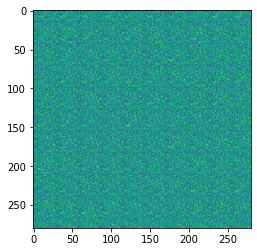

Epoch: 0/30, Step: 500, D Loss: 1.2046184539794922, G Loss: 0.9408228397369385
Epoch: 1/30, Step: 1000, D Loss: 1.3073017597198486, G Loss: 1.0394192934036255


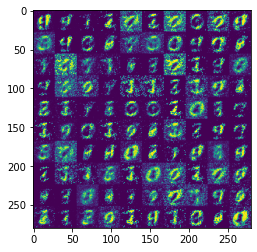

Epoch: 1/30, Step: 1500, D Loss: 1.134286880493164, G Loss: 1.2036218643188477
Epoch: 2/30, Step: 2000, D Loss: 1.2170333862304688, G Loss: 0.9931835532188416


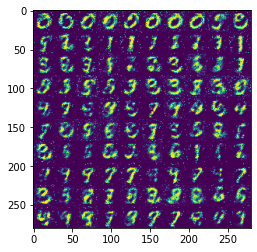

Epoch: 2/30, Step: 2500, D Loss: 1.2142579555511475, G Loss: 1.105323076248169
Epoch: 3/30, Step: 3000, D Loss: 1.2408497333526611, G Loss: 0.763992965221405


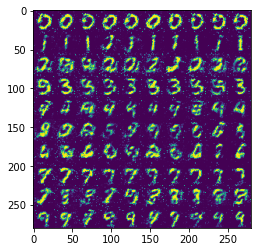

Epoch: 3/30, Step: 3500, D Loss: 1.2661914825439453, G Loss: 1.2293777465820312
Epoch: 4/30, Step: 4000, D Loss: 1.207857370376587, G Loss: 0.9183690547943115


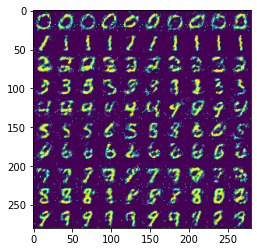

Epoch: 4/30, Step: 4500, D Loss: 1.3061097860336304, G Loss: 0.8324016332626343
Epoch: 5/30, Step: 5000, D Loss: 1.2504677772521973, G Loss: 1.1207141876220703


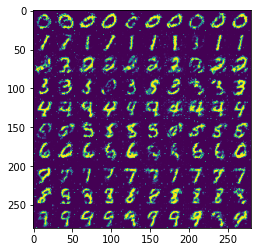

Epoch: 5/30, Step: 5500, D Loss: 1.2903385162353516, G Loss: 0.8263170719146729
Epoch: 6/30, Step: 6000, D Loss: 1.2901036739349365, G Loss: 0.940766453742981


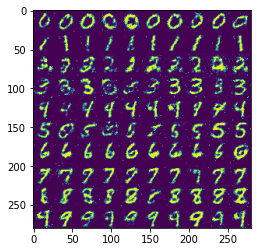

Epoch: 6/30, Step: 6500, D Loss: 1.2913693189620972, G Loss: 0.8801758885383606
Epoch: 7/30, Step: 7000, D Loss: 1.3129987716674805, G Loss: 1.0173052549362183


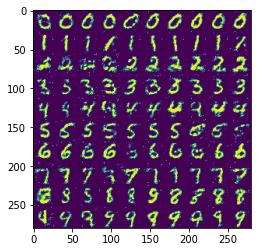

Epoch: 8/30, Step: 7500, D Loss: 1.2541556358337402, G Loss: 0.7325360774993896
Epoch: 8/30, Step: 8000, D Loss: 1.3293712139129639, G Loss: 0.9169298410415649


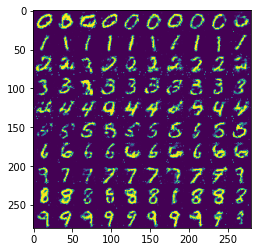

Epoch: 9/30, Step: 8500, D Loss: 1.2895727157592773, G Loss: 0.9138822555541992
Epoch: 9/30, Step: 9000, D Loss: 1.3756561279296875, G Loss: 0.6995124220848083


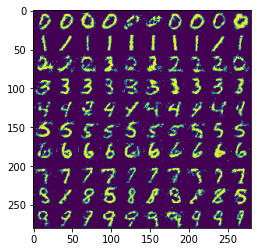

Epoch: 10/30, Step: 9500, D Loss: 1.3811142444610596, G Loss: 0.7480807304382324
Epoch: 10/30, Step: 10000, D Loss: 1.4004484415054321, G Loss: 0.7860670685768127


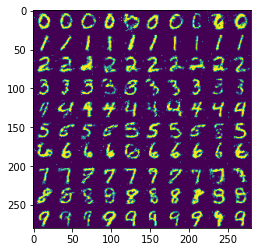

Epoch: 11/30, Step: 10500, D Loss: 1.3089038133621216, G Loss: 0.88142329454422
Epoch: 11/30, Step: 11000, D Loss: 1.3444994688034058, G Loss: 0.7450730800628662


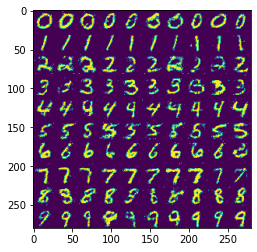

Epoch: 12/30, Step: 11500, D Loss: 1.3550045490264893, G Loss: 0.9536592960357666
Epoch: 12/30, Step: 12000, D Loss: 1.3411914110183716, G Loss: 0.8089522123336792


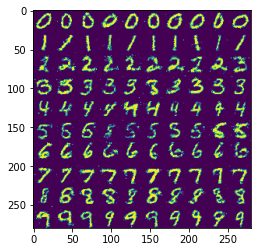

Epoch: 13/30, Step: 12500, D Loss: 1.2770867347717285, G Loss: 0.7556033730506897
Epoch: 13/30, Step: 13000, D Loss: 1.3162190914154053, G Loss: 0.7500275373458862


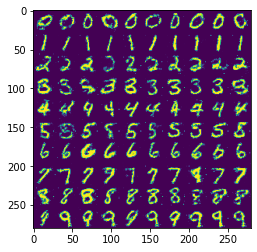

Epoch: 14/30, Step: 13500, D Loss: 1.320892333984375, G Loss: 0.7980104088783264
Epoch: 14/30, Step: 14000, D Loss: 1.3321549892425537, G Loss: 0.8206861019134521


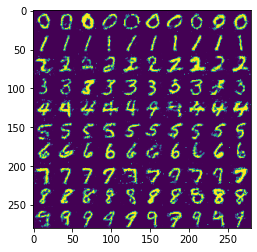

Epoch: 15/30, Step: 14500, D Loss: 1.376128911972046, G Loss: 0.7544758319854736
Epoch: 16/30, Step: 15000, D Loss: 1.3420710563659668, G Loss: 0.7008988261222839


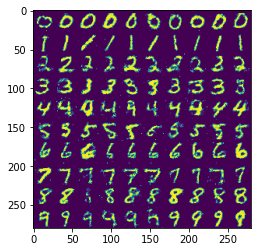

Epoch: 16/30, Step: 15500, D Loss: 1.359119176864624, G Loss: 0.759272575378418
Epoch: 17/30, Step: 16000, D Loss: 1.3452277183532715, G Loss: 0.7256717085838318


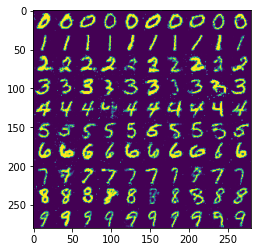

Epoch: 17/30, Step: 16500, D Loss: 1.3340981006622314, G Loss: 0.7309566736221313
Epoch: 18/30, Step: 17000, D Loss: 1.378564476966858, G Loss: 0.6337918043136597


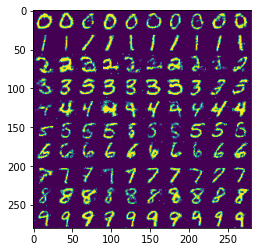

Epoch: 18/30, Step: 17500, D Loss: 1.3395739793777466, G Loss: 0.8300781846046448
Epoch: 19/30, Step: 18000, D Loss: 1.31901216506958, G Loss: 0.859110414981842


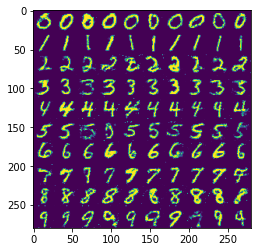

Epoch: 19/30, Step: 18500, D Loss: 1.3342422246932983, G Loss: 0.6799917817115784
Epoch: 20/30, Step: 19000, D Loss: 1.3369232416152954, G Loss: 0.8353976011276245


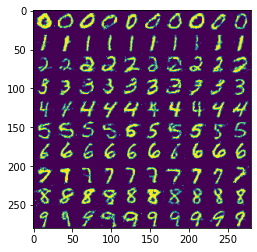

Epoch: 20/30, Step: 19500, D Loss: 1.400702953338623, G Loss: 0.8132588863372803
Epoch: 21/30, Step: 20000, D Loss: 1.3457765579223633, G Loss: 0.8389352560043335


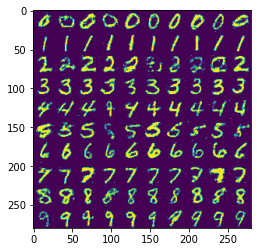

Epoch: 21/30, Step: 20500, D Loss: 1.3239833116531372, G Loss: 0.6359607577323914
Epoch: 22/30, Step: 21000, D Loss: 1.3706738948822021, G Loss: 0.8130353093147278


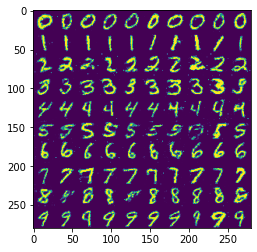

Epoch: 22/30, Step: 21500, D Loss: 1.347963571548462, G Loss: 0.7320236563682556
Epoch: 23/30, Step: 22000, D Loss: 1.3688297271728516, G Loss: 0.7925962805747986


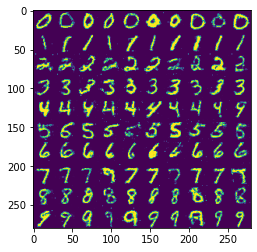

Epoch: 24/30, Step: 22500, D Loss: 1.384650707244873, G Loss: 0.822009801864624
Epoch: 24/30, Step: 23000, D Loss: 1.3551353216171265, G Loss: 0.7418942451477051


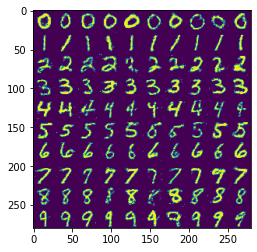

Epoch: 25/30, Step: 23500, D Loss: 1.3486261367797852, G Loss: 0.8144084215164185
Epoch: 25/30, Step: 24000, D Loss: 1.3419415950775146, G Loss: 0.7981106042861938


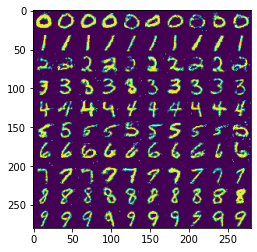

Epoch: 26/30, Step: 24500, D Loss: 1.2778711318969727, G Loss: 0.7869999408721924
Epoch: 26/30, Step: 25000, D Loss: 1.3419121503829956, G Loss: 0.7396997809410095


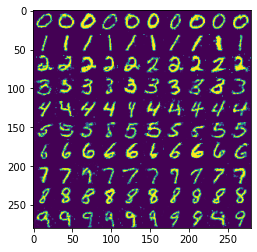

Epoch: 27/30, Step: 25500, D Loss: 1.353055715560913, G Loss: 0.848422110080719
Epoch: 27/30, Step: 26000, D Loss: 1.3116281032562256, G Loss: 0.63956218957901


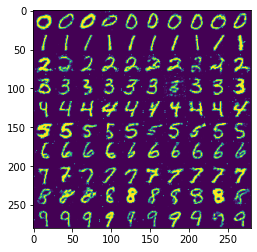

Epoch: 28/30, Step: 26500, D Loss: 1.405773639678955, G Loss: 0.7905025482177734
Epoch: 28/30, Step: 27000, D Loss: 1.3729743957519531, G Loss: 0.8991107940673828


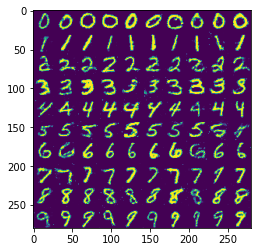

Epoch: 29/30, Step: 27500, D Loss: 1.348362684249878, G Loss: 0.7639046907424927
Epoch: 29/30, Step: 28000, D Loss: 1.2604286670684814, G Loss: 0.8143118619918823


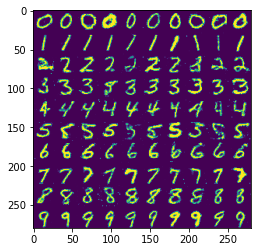

In [20]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imshow(img)
            show()
            G.train()
        step += 1

## Sample

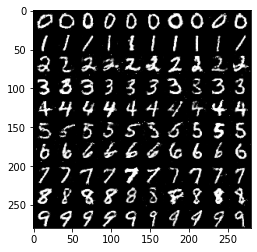

In [24]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [22]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [23]:
# Saving params.
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_c.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_c.pth.tar')